<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/5_hog_clahe_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier  # Add XGBoost library
from skimage.feature import hog

In [ ]:
# Definitions
classifiers_names = [
    "KNeighborsClassifier",
    "SVC",
    'MultinomialNB',
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "XGBClassifier"  # Add XGBoost
]

classifiers = [
    KNeighborsClassifier(),
    SVC(probability=True),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()  # Add XGBoost
]

parameters = [
    {'n_neighbors': [3, 5, 7, 9, 11, 13]},  # KNeighborsClassifier
    {'C': [1, 10, 50, 70, 100], 'gamma':['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight': [None, 'balanced']}, # SVC
    {'alpha': [0.1, 0.5, 1.0]},  # MultinomialNB
    {'max_depth': [None, 3, 5, 7, 10]},  # DecisionTreeClassifier
    {'n_estimators': [50, 100, 200, 300, 500], 'warm_start': [True, False], 'n_jobs':[None, 1, 2, 3]},  # RandomForestClassifier
    {  # XGBoost parameters
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [50, 100, 200],
        'gamma': [0, 1, 2],
        'subsample': [0.8, 0.9, 1.0]
    }
]

In [14]:
# Paths to dataset folders
base_path = "/content/drive/MyDrive/knee osteo 3"  # Change to your dataset path

# Define class labels for multi-class problem
class_labels = ["healthy", "ill", "minimal", "moderate", "doubtful"]

dataset_images_names = []
dataset_images = []  # Fixed variable name
dataset_labels = []

# Define a function to apply CLAHE to an image
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)
    return clahe_image

# Define a function to extract HOG features from an image
def extract_hog_features(image):
    # You can adjust HOG parameters as needed
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return fd

for label in class_labels:
    label_path = os.path.join(base_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith(".jpg"):
            filepath = os.path.join(label_path, filename)
            image = cv2.imread(filepath)

            if image is not None and not image.size == 0:
                size = (128, 128)
                image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)

                # Apply CLAHE to enhance image contrast
                image = apply_clahe(image)

                # Extract HOG features from the CLAHE-enhanced image
                hog_features = extract_hog_features(image)

                dataset_images.append(hog_features)  # Append HOG features
                dataset_labels.append(label)
            else:
                print(f"Error loading or resizing image: {filepath}")

# Convert labels to numerical values
class_to_idx = {class_labels[i]: i for i in range(len(class_labels))}
dataset_labels = [class_to_idx[label] for label in dataset_labels]

# Shuffle the dataset
combined_arrays = list(zip(dataset_images, dataset_labels))
random.shuffle(combined_arrays)
shuffled_images, shuffled_labels = zip(*combined_arrays)
dataset_images = np.array(shuffled_images)
dataset_labels = np.array(shuffled_labels)

# Perform LDA for feature extraction on HOG features
lda = LDA(n_components=3)  # You can adjust the number of components as needed
dataset_features = lda.fit_transform(dataset_images, dataset_labels)

# Apply Min-Max scaling to the dataset
scaler = MinMaxScaler()
scaled_dataset_features = scaler.fit_transform(dataset_features)

In [17]:
best_models = []
acc_cross = []
var_cross = []
pred_reports = []
pred_cross = []
roc_curves = []
auc_scores = []

for i in range(len(classifiers)):
    model = classifiers[i]
    model_name = classifiers_names[i]
    param_grid = parameters[i]

    # Grid Search for best parameters of models in terms of accuracy
    best_model = GridSearchCV(model, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # Model Fitting
    best_model.fit(scaled_dataset_features, dataset_labels)
    best_models.append(best_model)

    # Checking the params
    params = best_model.get_params()
    print(f'{model_name} -> {params}')

    # SCORING
    cv_accuracy = cross_val_score(best_model.best_estimator_, scaled_dataset_features, dataset_labels, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

    # ACCURACY
    print(f'{model_name} - Accuracy using cross-validation: {cv_accuracy.mean()*100.0} %')
    acc_cross.append(f'{cv_accuracy.mean()*100.0} %')

    # VARIANCE
    print(f'{model_name} - Variance using cross-validation: {cv_accuracy.var()*100.0} %')
    var_cross.append(f'{cv_accuracy.var()}')
    print()

    # PREDICTIONS
    cv_predict = cross_val_predict(best_model.best_estimator_, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))
    classes = class_labels
    pred_reports.append(classification_report(dataset_labels, cv_predict, target_names=classes))
    pred_cross.append(cv_predict)

    print(f'Done with classification: {model_name}')


KNeighborsClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
KNeighborsClassifier - Accuracy using cross-validation: 97.42597711347712 %
KNeighborsClassifier - Variance using cross-validation: 0.00312938786968569 %

Done with classification: KNeighborsClassifier
SVC -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 

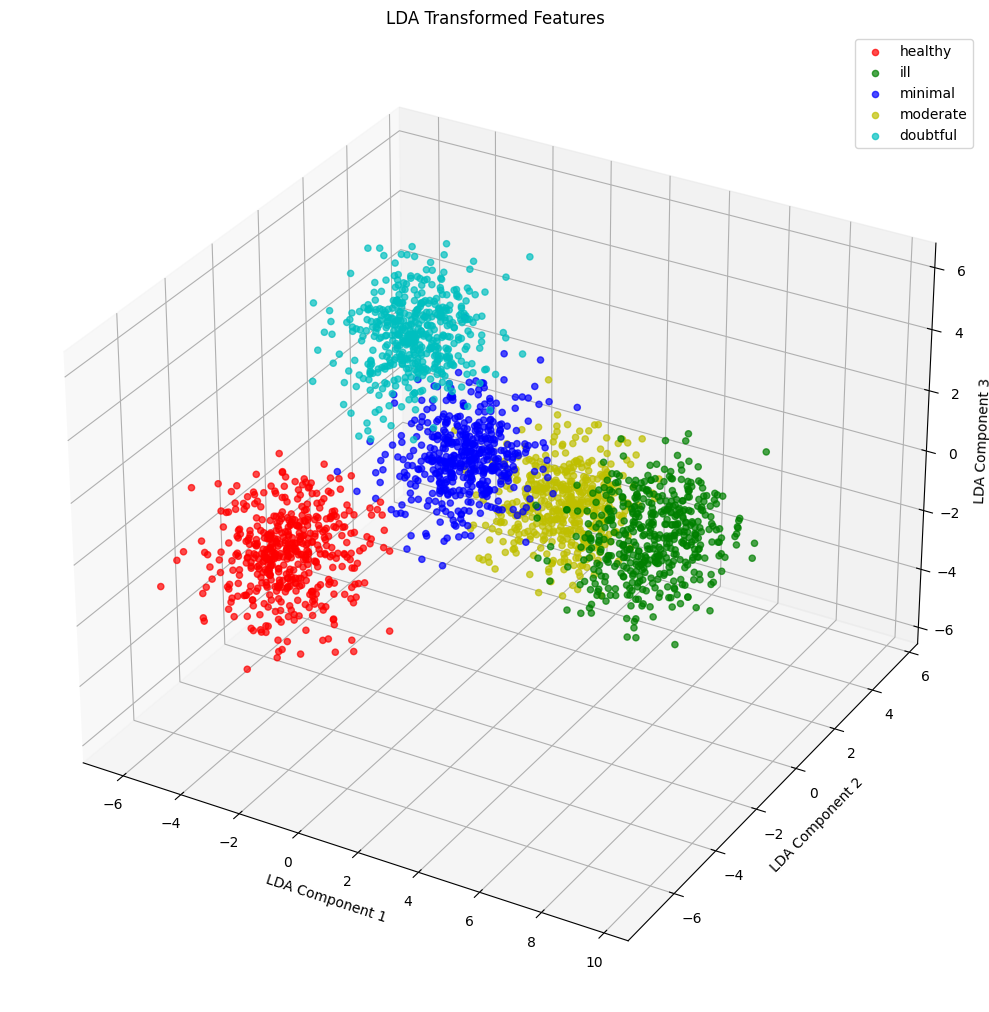

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Assuming you have already performed LDA with 3 components and stored the results in 'scaled_dataset_features'
# and 'dataset_labels'

# Create an LDA instance with 3 components
lda = LDA(n_components=3)

# Fit and transform the data using LDA
lda_features = lda.fit_transform(scaled_dataset_features, dataset_labels)

# Define class labels and colors
class_labels = ["healthy", "ill", "minimal", "moderate", "doubtful"]
colors = ['r', 'g', 'b', 'y', 'c']  # Add an extra color for the "doubtful" class

# Create a 3D scatter plot of the LDA-transformed features
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(class_labels)):
    ax.scatter(lda_features[dataset_labels == i, 0], lda_features[dataset_labels == i, 1], lda_features[dataset_labels == i, 2],
               c=colors[i], label=class_labels[i], alpha=0.7)

# Set plot labels and legend
ax.set_xlabel('LDA Component 1')
ax.set_ylabel('LDA Component 2')
ax.set_zlabel('LDA Component 3')
ax.set_title('LDA Transformed Features')
ax.legend()

# Show the 3D plot
plt.tight_layout()
plt.show()


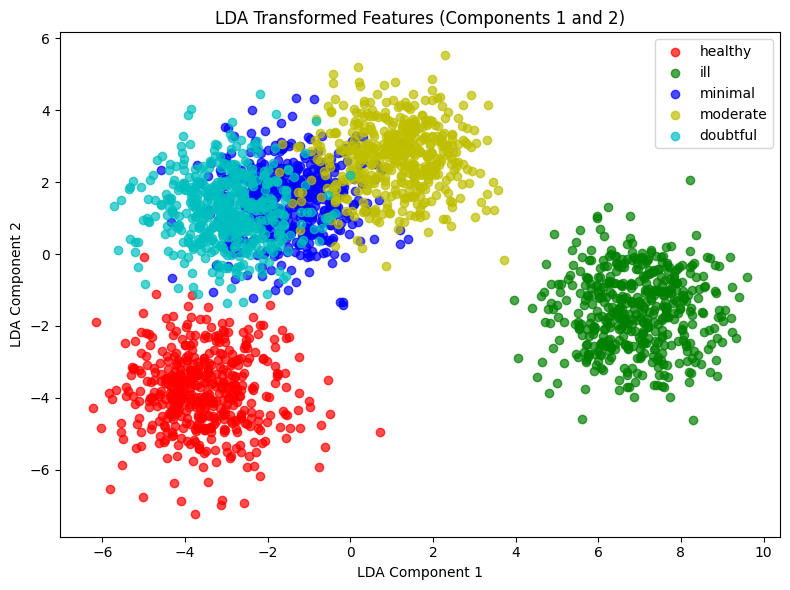

In [20]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Assuming you have already performed LDA with 3 components and stored the results in 'scaled_dataset_features'
# and 'dataset_labels'

# Create an LDA instance with 3 components
lda = LDA(n_components=3)

# Fit and transform the data using LDA
lda_features = lda.fit_transform(scaled_dataset_features, dataset_labels)

# Choose the two components you want to visualize (e.g., components 1 and 2)
component1 = 0  # Index of the first component (0-based)
component2 = 1  # Index of the second component (0-based)

# Define class labels and colors
class_labels = ["healthy", "ill", "minimal", "moderate", "doubtful"]
colors = ['r', 'g', 'b', 'y','c']

# Create a 2D scatter plot of the selected LDA components
plt.figure(figsize=(8, 6))

for i in range(len(class_labels)):
    plt.scatter(lda_features[dataset_labels == i, component1], lda_features[dataset_labels == i, component2],
                c=colors[i], label=class_labels[i], alpha=0.7)

# Set plot labels and legend
plt.xlabel(f'LDA Component {component1 + 1}')
plt.ylabel(f'LDA Component {component2 + 1}')
plt.title(f'LDA Transformed Features (Components {component1 + 1} and {component2 + 1})')
plt.legend()

# Show the 2D scatter plot
plt.tight_layout()
plt.show()


Best parameters for KNeighborsClassifier: {'n_neighbors': 7}
Model parameters for KNeighborsClassifier -> {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Accuracy using cross-validation: 97.42597711347712 %
Variance using cross-validation: 3.12938786968569e-05


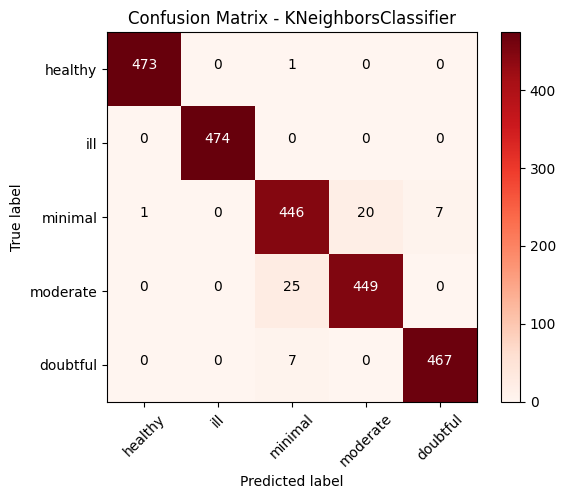

Classification Report - KNeighborsClassifier:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



Best parameters for SVC: {'C': 70, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Model parameters for SVC -> {'C': 70, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy using cross-validation: 97.5951804076804 %
Variance using 

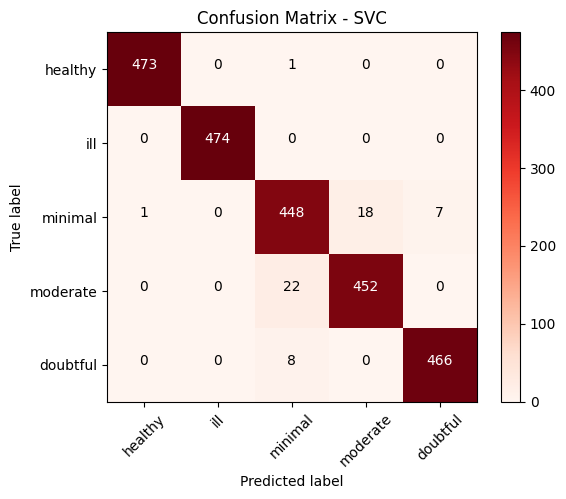

Classification Report - SVC:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



Best parameters for MultinomialNB: {'alpha': 1.0}
Model parameters for MultinomialNB -> {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Accuracy using cross-validation: 87.84793316043316 %
Variance using cross-validation: 2.8900438476385183e-05


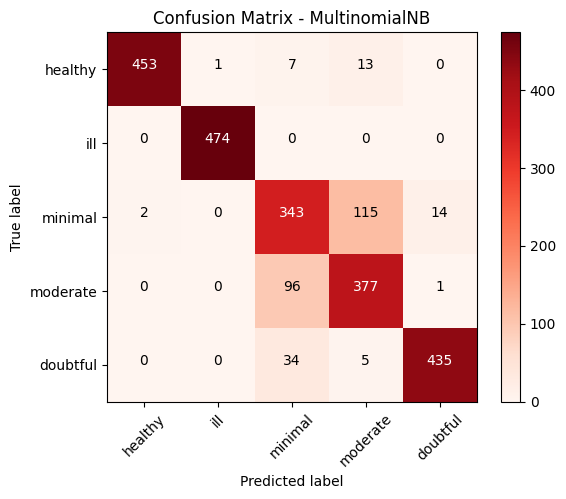

Classification Report - MultinomialNB:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



Best parameters for DecisionTreeClassifier: {'max_depth': 10}
Model parameters for DecisionTreeClassifier -> {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy using cross-validation: 95.99173036673037 %
Variance using cross-validation

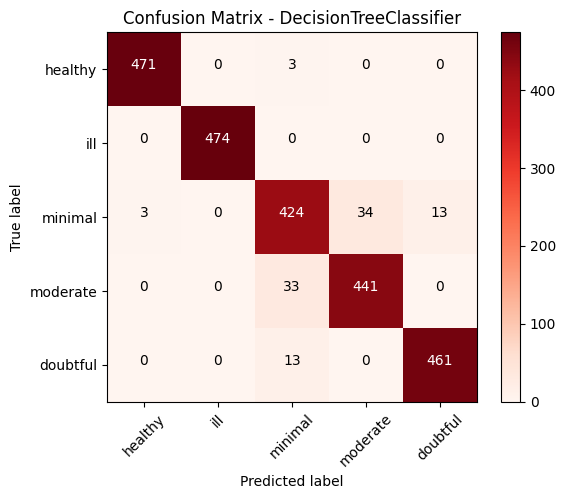

Classification Report - DecisionTreeClassifier:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



Best parameters for RandomForestClassifier: {'n_estimators': 100, 'n_jobs': 2, 'warm_start': True}
Model parameters for RandomForestClassifier -> {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 2, 'o

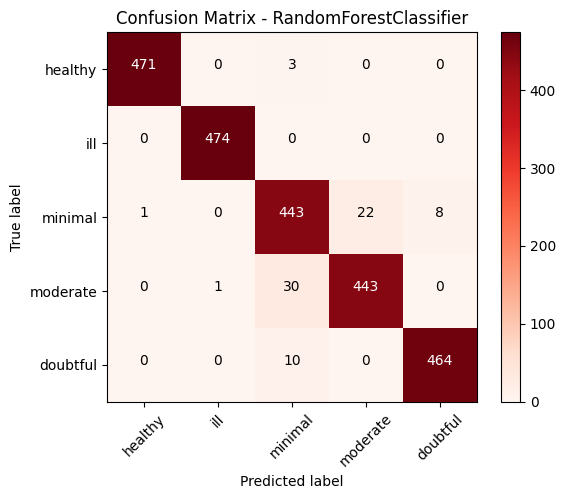

Classification Report - RandomForestClassifier:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



Best parameters for XGBClassifier: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Model parameters for XGBClassifier -> {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0,

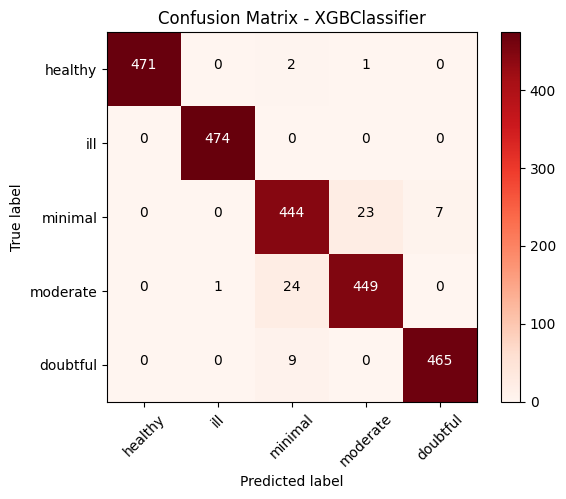

Classification Report - XGBClassifier:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.91      0.93      0.92       474
    moderate       0.95      0.93      0.94       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370





In [21]:
# PARAMETERS, ACCURACIES, VARIANCES, CONFUSION MATRICES, CLASSIFICATION REPORT

for i in range(len(best_models)):
    # name
    model_name = classifiers_names[i]

    # Checking the best parameters
    best_params = best_models[i].best_params_
    print(f'Best parameters for {model_name}: {best_params}')

    # Checking the params of the best model
    params = best_models[i].best_estimator_.get_params()
    print(f'Model parameters for {model_name} -> {params}')

    # ACCURACY
    print(f'Accuracy using cross-validation: {acc_cross[i]}')

    # VARIANCE
    print(f'Variance using cross-validation: {var_cross[i]}')

    # CONFUSION MATRICES
    cm = confusion_matrix(dataset_labels, pred_cross[i])

    # Create a custom red colormap
    custom_cmap = plt.cm.Reds  # Use Reds colormap for red color

    plt.imshow(cm, interpolation='nearest', cmap=custom_cmap)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Annotate the confusion matrix with numbers
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()

    # CLASSIFICATION REPORT
    print(f'Classification Report - {model_name}:')
    print(pred_reports[i])

    print()
    print()


In [22]:
class_counts = {label: np.sum(dataset_labels == class_to_idx[label]) for label in class_labels}
total_samples = len(dataset_labels)

for label, count in class_counts.items():
    print(f"Class '{label}': {count} samples")

print(f"Total number of samples: {total_samples}")


Class 'healthy': 474 samples
Class 'ill': 474 samples
Class 'minimal': 474 samples
Class 'moderate': 474 samples
Class 'doubtful': 474 samples
Total number of samples: 2370


In [23]:
from sklearn.ensemble import VotingClassifier
#Create a list of (model_name, model) tuples for the VotingClassifier
ensemble_models = []

for i in range(len(best_models)):
    model_name = classifiers_names[i]
    model = best_models[i].best_estimator_
    ensemble_models.append((model_name, model))

# Create the VotingClassifier
ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')  # You can choose 'soft' or 'hard' voting

# Fit the ensemble model on your dataset
ensemble.fit(scaled_dataset_features, dataset_labels)

# Make predictions using the ensemble model
ensemble_predictions = cross_val_predict(ensemble, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(dataset_labels, ensemble_predictions)
print(f'Ensemble Model - Accuracy using cross-validation: {ensemble_accuracy * 100.0} %')

Ensemble Model - Accuracy using cross-validation: 97.13080168776371 %


Ensemble Model - Accuracy using cross-validation: 97.13080168776371 %
Ensemble Model - Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       474
         ill       1.00      1.00      1.00       474
     minimal       0.92      0.94      0.93       474
    moderate       0.96      0.95      0.95       474
    doubtful       0.98      0.98      0.98       474

    accuracy                           0.97      2370
   macro avg       0.97      0.97      0.97      2370
weighted avg       0.97      0.97      0.97      2370



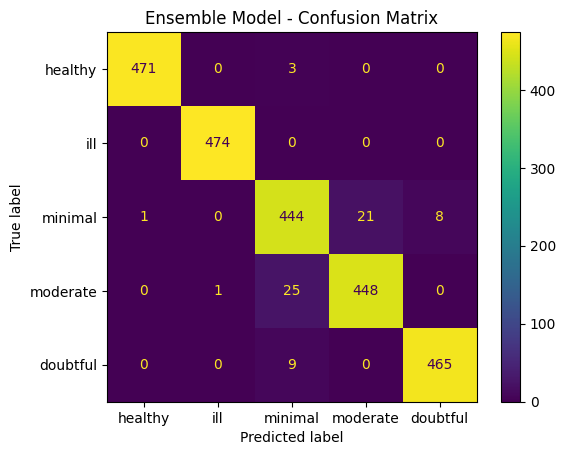

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Create a list of all your trained models
all_models = [
    ('KNeighborsClassifier', best_models[0].best_estimator_),
    ('SVC', best_models[1].best_estimator_),
    ('MultinomialNB', best_models[2].best_estimator_),
    ('DecisionTreeClassifier', best_models[3].best_estimator_),
    ('RandomForestClassifier', best_models[4].best_estimator_),
    ('XGBClassifier', best_models[5].best_estimator_),
    # Add more models here if you have more
]

# Create a Voting Classifier with all the models
ensemble = VotingClassifier(estimators=all_models, voting='soft')  # You can choose 'soft' or 'hard' voting

# Make predictions using the ensemble model
ensemble_predictions = cross_val_predict(ensemble, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8))

# Calculate the accuracy of the ensemble model
ensemble_accuracy = accuracy_score(dataset_labels, ensemble_predictions)
print(f'Ensemble Model - Accuracy using cross-validation: {ensemble_accuracy * 100.0} %')

# Generate other evaluation metrics (classification report, confusion matrix, etc.) for the ensemble model as needed
ensemble_classification_report = classification_report(dataset_labels, ensemble_predictions, target_names=class_labels)
print('Ensemble Model - Classification Report:')
print(ensemble_classification_report)

# Calculate the confusion matrix for the ensemble model
ensemble_confusion_matrix = confusion_matrix(dataset_labels, ensemble_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_confusion_matrix, display_labels=class_labels)
disp.plot(cmap='viridis', values_format='d')
plt.title('Ensemble Model - Confusion Matrix')
plt.show()

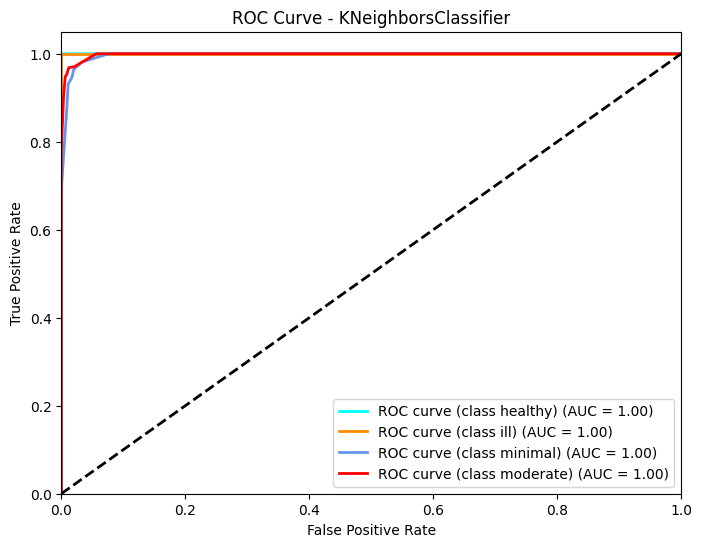

KNeighborsClassifier - AUC (class healthy): 1.00
KNeighborsClassifier - AUC (class ill): 1.00
KNeighborsClassifier - AUC (class minimal): 1.00
KNeighborsClassifier - AUC (class moderate): 1.00
KNeighborsClassifier - AUC (class doubtful): 1.00



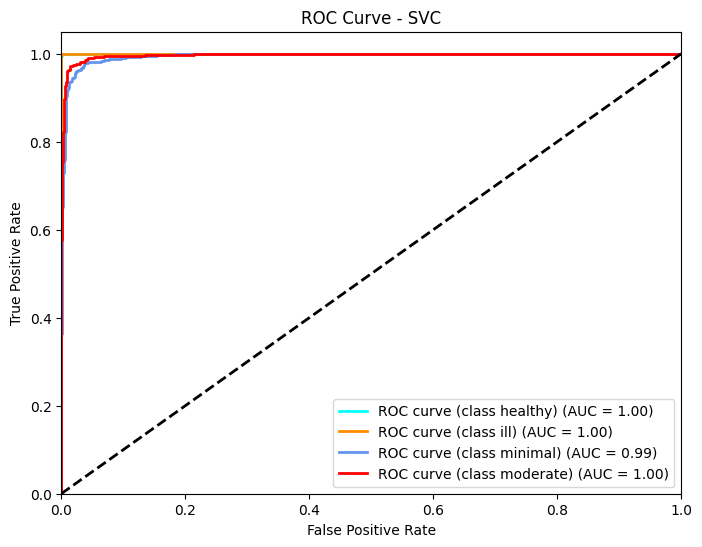

SVC - AUC (class healthy): 1.00
SVC - AUC (class ill): 1.00
SVC - AUC (class minimal): 0.99
SVC - AUC (class moderate): 1.00
SVC - AUC (class doubtful): 1.00



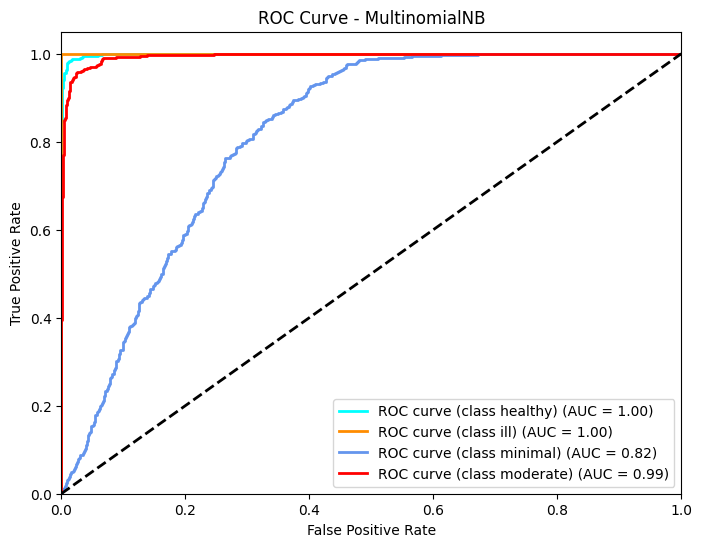

MultinomialNB - AUC (class healthy): 1.00
MultinomialNB - AUC (class ill): 1.00
MultinomialNB - AUC (class minimal): 0.82
MultinomialNB - AUC (class moderate): 0.99
MultinomialNB - AUC (class doubtful): 0.99



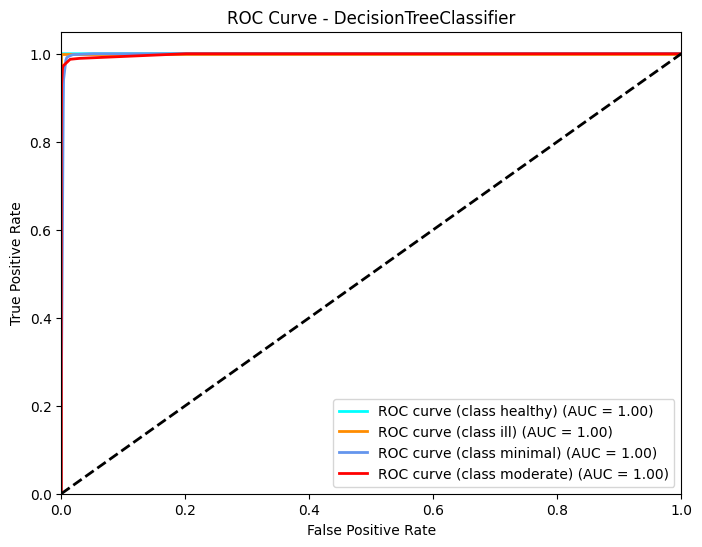

DecisionTreeClassifier - AUC (class healthy): 1.00
DecisionTreeClassifier - AUC (class ill): 1.00
DecisionTreeClassifier - AUC (class minimal): 1.00
DecisionTreeClassifier - AUC (class moderate): 1.00
DecisionTreeClassifier - AUC (class doubtful): 1.00



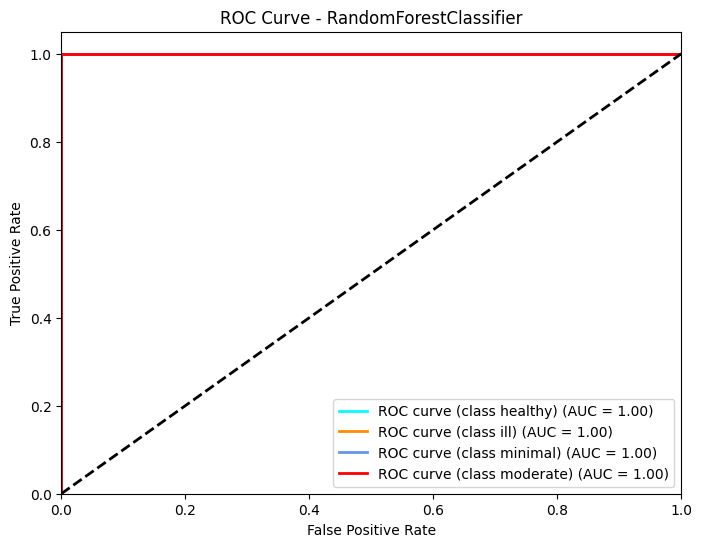

RandomForestClassifier - AUC (class healthy): 1.00
RandomForestClassifier - AUC (class ill): 1.00
RandomForestClassifier - AUC (class minimal): 1.00
RandomForestClassifier - AUC (class moderate): 1.00
RandomForestClassifier - AUC (class doubtful): 1.00



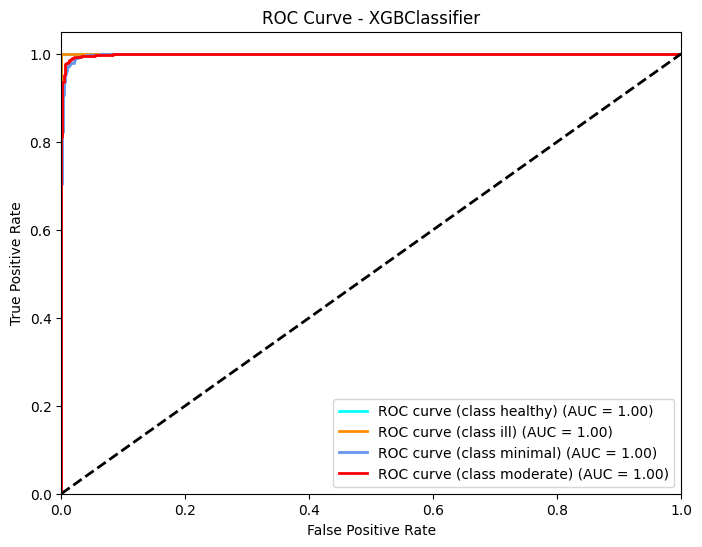

XGBClassifier - AUC (class healthy): 1.00
XGBClassifier - AUC (class ill): 1.00
XGBClassifier - AUC (class minimal): 1.00
XGBClassifier - AUC (class moderate): 1.00
XGBClassifier - AUC (class doubtful): 1.00



In [25]:
# @title ROC CURVES AND AUC SCORES

for i in range(len(best_models)):
    model_name = classifiers_names[i]

    # Get the best model from GridSearchCV
    best_model = best_models[i].best_estimator_

    # Compute ROC curve and AUC for each class
    y_scores = best_model.predict_proba(scaled_dataset_features)
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(np.array(dataset_labels) == j, y_scores[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
    for j, color in zip(range(n_classes), colors):
        plt.plot(fpr[j], tpr[j], color=color, lw=2, label=f'ROC curve (class {class_labels[j]}) (AUC = {roc_auc[j]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC scores
    for j in range(n_classes):
        print(f'{model_name} - AUC (class {class_labels[j]}): {roc_auc[j]:.2f}')

    print()


In [26]:
# @title SENSITIVITY (True Positive Rate) AND SPECIFICITY (True Negative Rate)

for i in range(len(best_models)):
    model_name = classifiers_names[i]

    # Get the best model from GridSearchCV
    best_model = best_models[i].best_estimator_

    # Compute ROC curve and AUC for each class
    y_scores = best_model.predict_proba(scaled_dataset_features)
    n_classes = len(class_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(np.array(dataset_labels) == j, y_scores[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    # Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
    sensitivity = dict()
    specificity = dict()

    for j in range(n_classes):
        # Create binary labels for the current class
        binary_labels = np.array(dataset_labels) == j

        # Get predicted labels for the current class
        predicted_labels = best_model.predict(scaled_dataset_features)

        # Calculate confusion matrix for the current class
        tn, fp, fn, tp = confusion_matrix(binary_labels, predicted_labels == j).ravel()

        # Calculate sensitivity and specificity for the current class
        sensitivity[j] = tp / (tp + fn)
        specificity[j] = tn / (tn + fp)

    # Print sensitivity and specificity for each class
    for j in range(n_classes):
        print(f'{model_name} - Sensitivity (class {class_labels[j]}): {sensitivity[j]:.2f}')
        print(f'{model_name} - Specificity (class {class_labels[j]}): {specificity[j]:.2f}')

    print()


KNeighborsClassifier - Sensitivity (class healthy): 1.00
KNeighborsClassifier - Specificity (class healthy): 1.00
KNeighborsClassifier - Sensitivity (class ill): 1.00
KNeighborsClassifier - Specificity (class ill): 1.00
KNeighborsClassifier - Sensitivity (class minimal): 0.95
KNeighborsClassifier - Specificity (class minimal): 0.98
KNeighborsClassifier - Sensitivity (class moderate): 0.95
KNeighborsClassifier - Specificity (class moderate): 0.99
KNeighborsClassifier - Sensitivity (class doubtful): 0.98
KNeighborsClassifier - Specificity (class doubtful): 1.00

SVC - Sensitivity (class healthy): 1.00
SVC - Specificity (class healthy): 1.00
SVC - Sensitivity (class ill): 1.00
SVC - Specificity (class ill): 1.00
SVC - Sensitivity (class minimal): 0.94
SVC - Specificity (class minimal): 0.98
SVC - Sensitivity (class moderate): 0.95
SVC - Specificity (class moderate): 0.99
SVC - Sensitivity (class doubtful): 0.99
SVC - Specificity (class doubtful): 1.00

MultinomialNB - Sensitivity (class h

Training examples: 207, Training score: 97.16%, Cross-validation score: 96.33%
Training examples: 673, Training score: 97.79%, Cross-validation score: 97.17%
Training examples: 1140, Training score: 97.73%, Cross-validation score: 96.96%
Training examples: 1606, Training score: 97.74%, Cross-validation score: 97.30%
Training examples: 2073, Training score: 97.58%, Cross-validation score: 97.43%


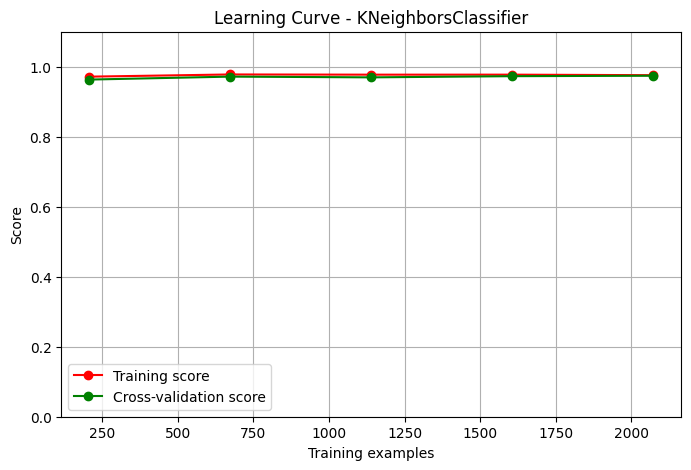

Training examples: 207, Training score: 98.07%, Cross-validation score: 96.84%
Training examples: 673, Training score: 97.75%, Cross-validation score: 97.47%
Training examples: 1140, Training score: 97.63%, Cross-validation score: 97.43%
Training examples: 1606, Training score: 97.69%, Cross-validation score: 97.34%
Training examples: 2073, Training score: 97.58%, Cross-validation score: 97.60%


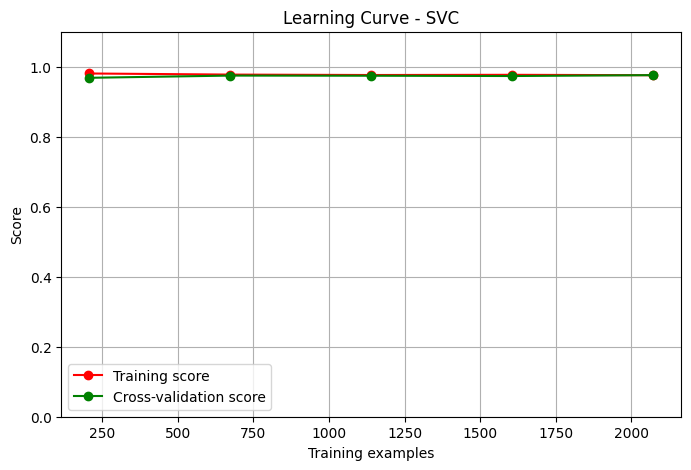

Training examples: 207, Training score: 60.87%, Cross-validation score: 55.48%
Training examples: 673, Training score: 69.17%, Cross-validation score: 68.02%
Training examples: 1140, Training score: 73.57%, Cross-validation score: 72.70%
Training examples: 1606, Training score: 75.76%, Cross-validation score: 75.95%
Training examples: 2073, Training score: 87.74%, Cross-validation score: 87.76%


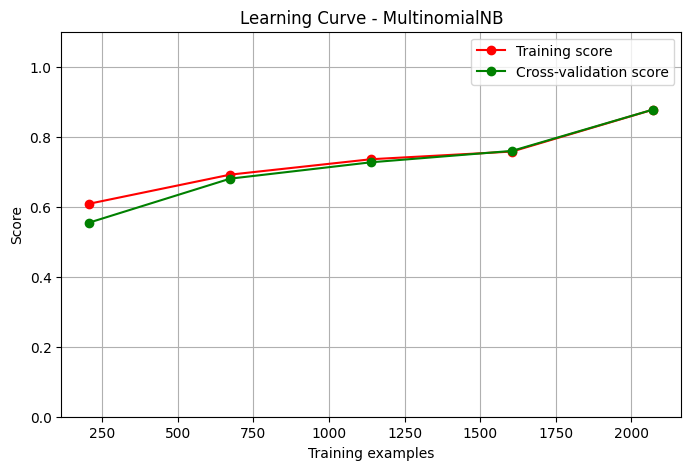

Training examples: 207, Training score: 100.00%, Cross-validation score: 94.35%
Training examples: 673, Training score: 99.65%, Cross-validation score: 94.72%
Training examples: 1140, Training score: 99.46%, Cross-validation score: 95.65%
Training examples: 1606, Training score: 99.38%, Cross-validation score: 95.87%
Training examples: 2073, Training score: 99.14%, Cross-validation score: 95.91%


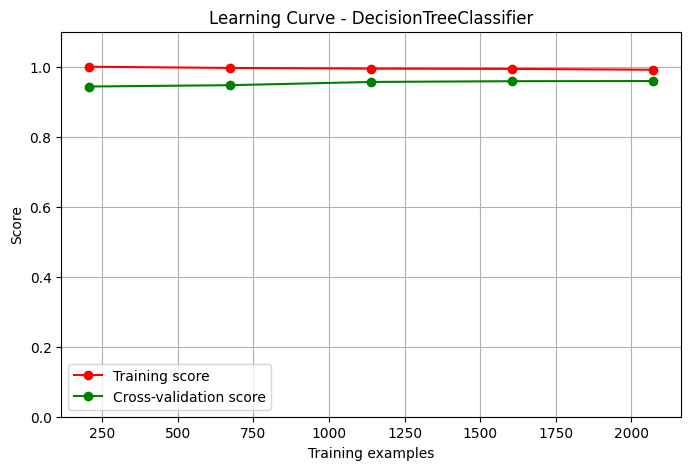

Training examples: 207, Training score: 100.00%, Cross-validation score: 95.15%
Training examples: 673, Training score: 100.00%, Cross-validation score: 96.54%
Training examples: 1140, Training score: 100.00%, Cross-validation score: 96.79%
Training examples: 1606, Training score: 99.99%, Cross-validation score: 96.88%
Training examples: 2073, Training score: 100.00%, Cross-validation score: 96.92%


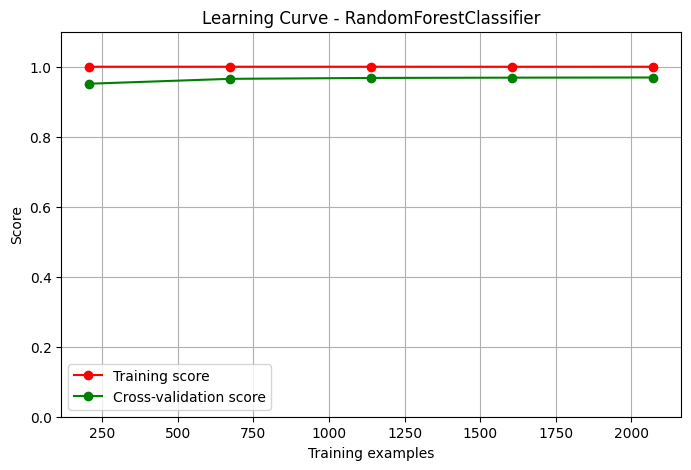

Training examples: 207, Training score: 100.00%, Cross-validation score: 95.15%
Training examples: 673, Training score: 99.35%, Cross-validation score: 96.54%
Training examples: 1140, Training score: 99.10%, Cross-validation score: 96.75%
Training examples: 1606, Training score: 98.86%, Cross-validation score: 97.05%
Training examples: 2073, Training score: 98.62%, Cross-validation score: 97.05%


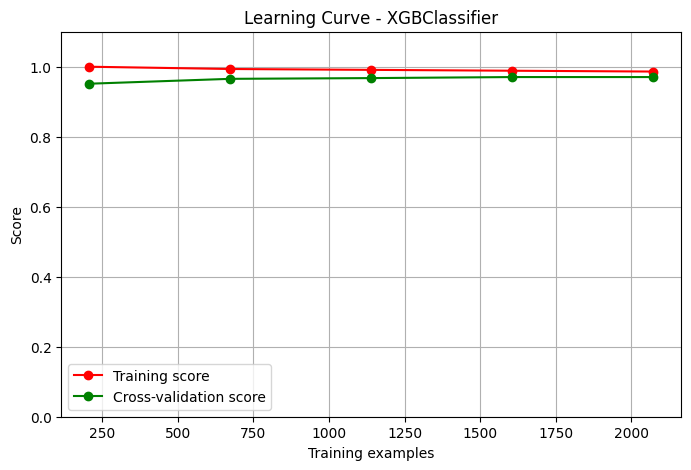

In [27]:
from sklearn.model_selection import learning_curve

# Define a function to plot learning curves and print scores
def plot_learning_curve_with_scores(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), score_intervals=10):
    plt.figure(figsize=(8, 5))  # Adjust figure size as needed
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    else:
        plt.ylim(0.0, 1.1)  # Adjust the y-axis limits as needed

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")

    # Ensure score_interval is at least 1
    score_interval = max(1, len(train_sizes) // score_intervals)

    for i in range(0, len(train_sizes), score_interval):
        print(f"Training examples: {int(train_sizes[i])}, Training score: {train_scores_mean[i] * 100:.2f}%, Cross-validation score: {test_scores_mean[i] * 100:.2f}%")

    return plt

# Now, for each classifier, you can plot the learning curve with scores
for i in range(len(best_models)):
    model = best_models[i].best_estimator_
    model_name = classifiers_names[i]

    title = f"Learning Curve - {model_name}"
    plot_learning_curve_with_scores(model, title, scaled_dataset_features, dataset_labels, cv=StratifiedKFold(n_splits=8), score_intervals=10)
    plt.show()


<ipython-input-28-f214dae10871>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=classifiers_names, palette='viridis')


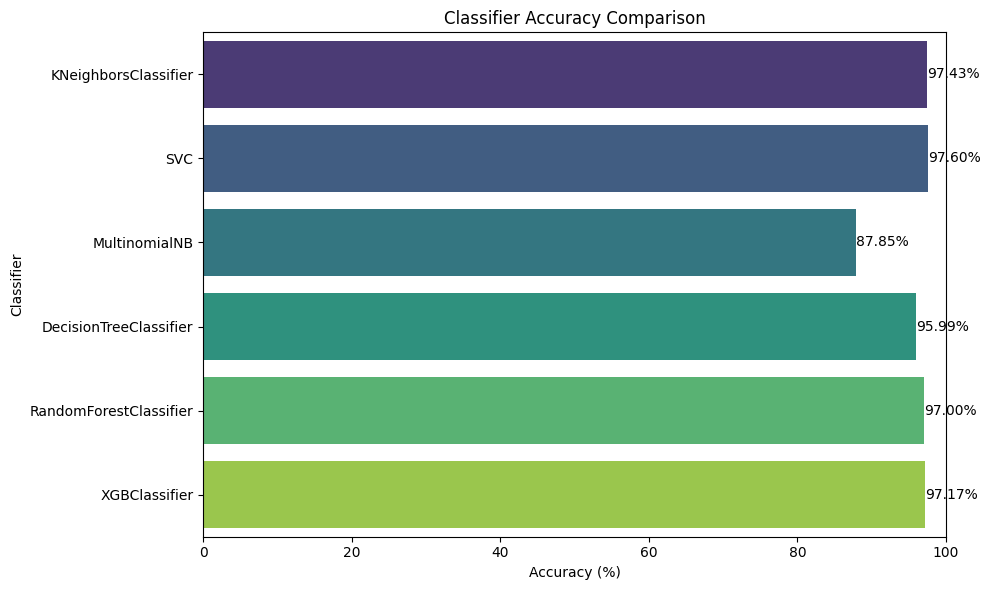

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace acc_cross with your actual list of accuracy values
accuracies = [float(acc.strip(' %')) for acc in acc_cross]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=classifiers_names, palette='viridis')
plt.xlabel('Accuracy (%)')
plt.ylabel('Classifier')
plt.title('Classifier Accuracy Comparison')

# Adding accuracy values as text on top of the bars
for i, v in enumerate(accuracies):
    plt.text(v, i, f'{v:.2f}%', ha='left', va='center', fontsize=10)

# Set the x-axis limit to 0 to 100 for accuracy scores
plt.xlim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-29-730acbaf623c>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=classifiers_names, palette='viridis', ax=axes[0])
<ipython-input-29-730acbaf623c>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=classifiers_names, palette='viridis', ax=axes[1])
<ipython-input-29-730acbaf623c>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=precision, y=classifiers_names, palette='viridis', ax=axes[2])
<ipython-input-29-730acbaf623c>:73: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

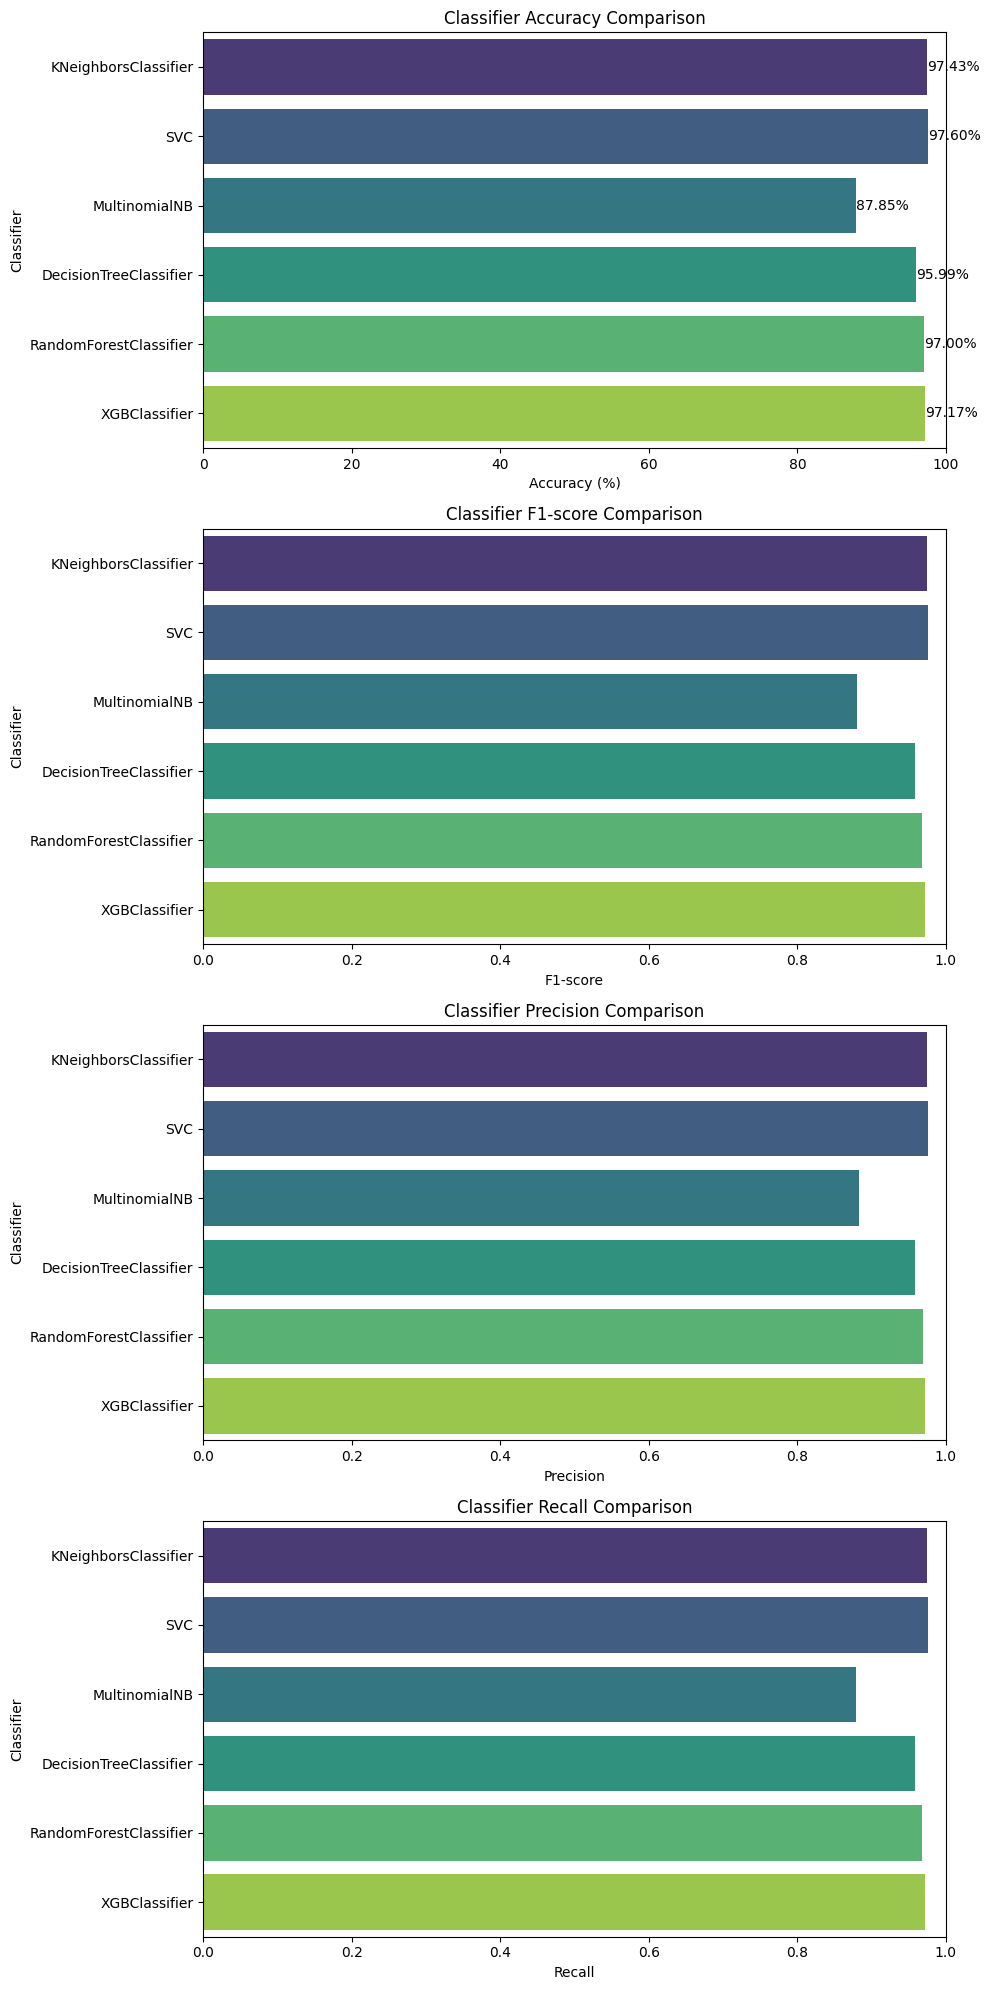

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score

# Replace acc_cross with your actual list of accuracy values
accuracies = [float(acc.strip(' %')) for acc in acc_cross]

# Replace pred_cross with your actual list of cross-validation predictions
# Each element should be an array of predicted labels for each fold
# You can use pred_cross[i] to access the predictions for the i-th classifier
f1_scores = []
precision = []
recall = []
auc_scores = []

for i in range(len(classifiers_names)):
    # Calculate confusion matrix for each classifier
    cm = confusion_matrix(dataset_labels, pred_cross[i])

    # Calculate precision and recall for each class
    tp = cm.diagonal()  # True positives
    fp = cm.sum(axis=0) - tp  # False positives
    fn = cm.sum(axis=1) - tp  # False negatives

    precision_i = tp / (tp + fp)
    recall_i = tp / (tp + fn)

    # Calculate F1-score for each class
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)

    # Calculate the weighted average of F1-scores, precision, and recall
    weighted_f1 = sum(f1_i) / len(f1_i)
    weighted_precision = sum(precision_i) / len(precision_i)
    weighted_recall = sum(recall_i) / len(recall_i)

    f1_scores.append(weighted_f1)
    precision.append(weighted_precision)
    recall.append(weighted_recall)

    # Calculate AUC score using ROC curve (binary classification)
    auc_i = roc_auc_score(dataset_labels, pred_cross[i], multi_class='ovr') if len(class_labels) == 2 else None
    auc_scores.append(auc_i)

# Create separate bar plots for each metric
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# Bar plot for Accuracy
sns.barplot(x=accuracies, y=classifiers_names, palette='viridis', ax=axes[0])
axes[0].set_xlabel('Accuracy (%)')
axes[0].set_ylabel('Classifier')
axes[0].set_title('Classifier Accuracy Comparison')

# Adding accuracy values as text on top of the bars
for i, v in enumerate(accuracies):
    axes[0].text(v, i, f'{v:.2f}%', ha='left', va='center', fontsize=10)
axes[0].set_xlim(0, 100)

# Bar plot for F1-score
sns.barplot(x=f1_scores, y=classifiers_names, palette='viridis', ax=axes[1])
axes[1].set_xlabel('F1-score')
axes[1].set_ylabel('Classifier')
axes[1].set_title('Classifier F1-score Comparison')
axes[1].set_xlim(0, 1)

# Bar plot for Precision
sns.barplot(x=precision, y=classifiers_names, palette='viridis', ax=axes[2])
axes[2].set_xlabel('Precision')
axes[2].set_ylabel('Classifier')
axes[2].set_title('Classifier Precision Comparison')
axes[2].set_xlim(0, 1)

# Bar plot for Recall
sns.barplot(x=recall, y=classifiers_names, palette='viridis', ax=axes[3])
axes[3].set_xlabel('Recall')
axes[3].set_ylabel('Classifier')
axes[3].set_title('Classifier Recall Comparison')
axes[3].set_xlim(0, 1)

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()


<ipython-input-30-46eec5072c11>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.1f}'.format(y) for y in plt.gca().get_yticks()])


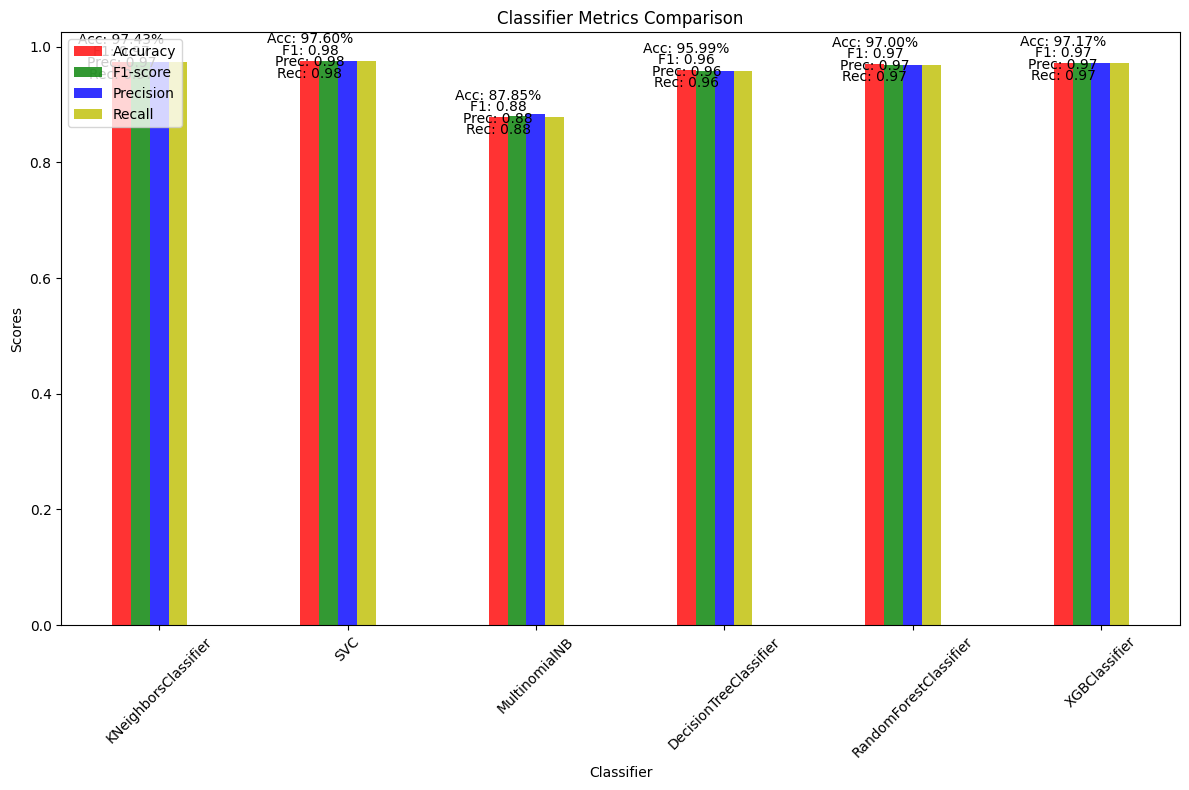

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace acc_cross with your actual list of accuracy values
accuracies = [float(acc.strip(' %')) / 100.0 for acc in acc_cross]

# Replace pred_cross with your actual list of cross-validation predictions
# Each element should be an array of predicted labels for each fold
# You can use pred_cross[i] to access the predictions for the i-th classifier
f1_scores = []
precision = []
recall = []

for i in range(len(classifiers_names)):
    # Calculate confusion matrix for each classifier
    cm = confusion_matrix(dataset_labels, pred_cross[i])

    # Calculate precision and recall for each class
    tp = cm.diagonal()  # True positives
    fp = cm.sum(axis=0) - tp  # False positives
    fn = cm.sum(axis=1) - tp  # False negatives

    precision_i = tp / (tp + fp)
    recall_i = tp / (tp + fn)

    # Calculate F1-score for each class
    f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)

    # Calculate the weighted average of F1-scores, precision, and recall
    weighted_f1 = sum(f1_i) / len(f1_i)
    weighted_precision = sum(precision_i) / len(precision_i)
    weighted_recall = sum(recall_i) / len(recall_i)

    f1_scores.append(weighted_f1)
    precision.append(weighted_precision)
    recall.append(weighted_recall)

# Create custom colors for the bars
colors = ['r', 'g', 'b', 'y']

# Create a grouped bar plot for all the scores
plt.figure(figsize=(12, 8))  # Adjust figure size

# Number of classifiers
n_classifiers = len(classifiers_names)

# Set the width of each bar
bar_width = 0.10

# Create an array for the x-axis positions of bars
index = np.arange(n_classifiers)

# Plot Accuracy
bars = plt.bar(index, accuracies, bar_width, label='Accuracy', color=colors[0], alpha=0.8)

# Plot F1-score
plt.bar(index + bar_width, f1_scores, bar_width, label='F1-score', color=colors[1], alpha=0.8)

# Plot Precision
plt.bar(index + 2 * bar_width, precision, bar_width, label='Precision', color=colors[2], alpha=0.8)

# Plot Recall
plt.bar(index + 3 * bar_width, recall, bar_width, label='Recall', color=colors[3], alpha=0.8)

# Set the x-axis labels
plt.xticks(index + 2 * bar_width, classifiers_names, rotation=45)

# Set axis labels and title
plt.xlabel('Classifier')
plt.ylabel('Scores')
plt.title('Classifier Metrics Comparison')

# Set the y-axis format to display scores as percentages (0.1 to 1.0)
plt.gca().set_yticklabels(['{:0.1f}'.format(y) for y in plt.gca().get_yticks()])

# Add accuracy, F1-score, precision, and recall values on top of the bars without overlap
for i, bar in enumerate(bars):
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height + 0.03, f'Acc: {accuracies[i]:.2%}', ha='center', fontsize=10, color='black')
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height + 0.01, f'F1: {f1_scores[i]:.2f}', ha='center', fontsize=10, color='black')
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.01, f'Prec: {precision[i]:.2f}', ha='center', fontsize=10, color='black')
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.03, f'Rec: {recall[i]:.2f}', ha='center', fontsize=10, color='black')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')